# Particle correlations in proton-proton collisions

Here, I run simulations of proton-proton collisions with [Chromo](https://github.com/impy-project/chromo) to investigate two-particle correlations in pseudorapidity space. With Chromo, it is very easy to study the output of different event generators.

I generate collisions at 13 TeV center-of-mass energy. For each event, I form all unique pairs of final-state charged particles, these are effectively long-lived prompt charged particles. Prompt here means that they either have no ancestors or that their ancestors are short-lived. I then fill the pseudorapidity pairs into a two-dimensional histogram.

We can see interesting patterns in these plots when different generators are compared. SIBYLL-2.3d shows a stronger concentration around mid-rapidity and has more pairs which are close in rapidity than the other generators.

In [1]:
import impy.models as im
from impy.kinematics import CenterOfMass
from impy.constants import TeV
import boost_histogram as bh
from matplotlib import pyplot as plt
import numba as nb
import numpy as np

In [2]:
ekin = CenterOfMass(13 * TeV, "proton", "proton")

@nb.njit
def pairs(eta, seed):
    r1 = []
    r2 = []
    np.random.seed(seed)
    for i, etai in enumerate(eta):
        for j in range(i):
            etaj = eta[j]
            # avoid structures that arise from implementation-specific
            # ordering of particles in HEPEVT record
            if np.random.uniform(0, 1) < 0.5:
                r1.append(etai)
                r2.append(etaj)
            else:
                r1.append(etaj)
                r2.append(etai)
    return np.array(r1), np.array(r2)

nevent = 1000

histograms = {}
for Model in (im.Sibyll21, im.Sibyll23d, im.QGSJetII04, im.EposLHC, im.Pythia6):
    h = bh.Histogram(bh.axis.Regular(300, -15, 15), bh.axis.Regular(300, -15, 15))
    for i, ev in enumerate(Model(ekin)(nevent)):
        fsc = ev.final_state_charged()
        with np.errstate(invalid="ignore", divide="ignore"):
            eta1, eta2 = pairs(fsc.eta, i)
        h.fill(eta1, eta2)
    histograms[Model] = h

 |                                                  |
 |                 S I B Y L L  2.1                 |
 |                                                  |
 |         HADRONIC INTERACTION MONTE CARLO         |
 |                        BY                        |
 |                   Ralph ENGEL                    |
 |           R.S. FLETCHER, T.K. GAISSER            |
 |               P. LIPARI, T. STANEV               |
 |                                                  |
 | Publication to be cited when using this program: |
 | R. Engel et al., Proc. 26th ICRC, 1 (1999) 415   |
 |                                                  |
 | last modified:  28. Sept. 2001 by R. Engel       |


 Table: J, sqs,  PT_cut,  SIG_tot,  SIG_inel,  B_el,  rho,  <n_s>,  <n_h>
 ------------------------------------------------------------------------
    1   1.000E+01    1.45   38.33   30.88   10.83  -0.185   1.964   0.003
    1   1.259E+01    1.49   38.27   31.16   11.10  -0.127   1.949   0.006


Sibyll21 0.020957722916460298
Sibyll23d 0.020768885431597404
QGSJetII04 0.02160297235716634
EposLHC 0.021529706058337213
Pythia6 0.022110986939247387


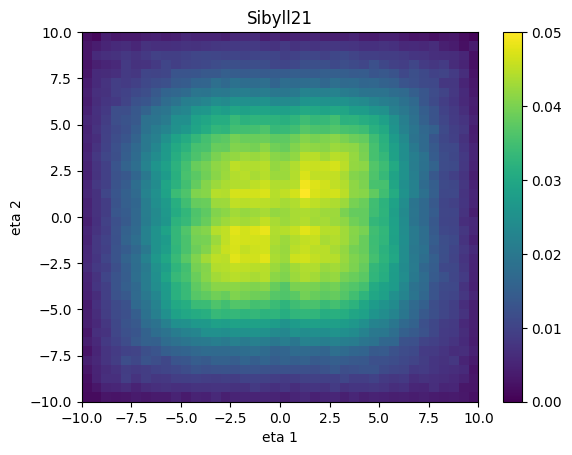

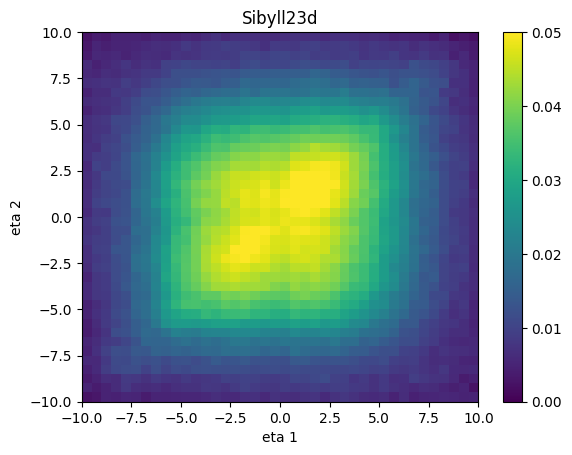

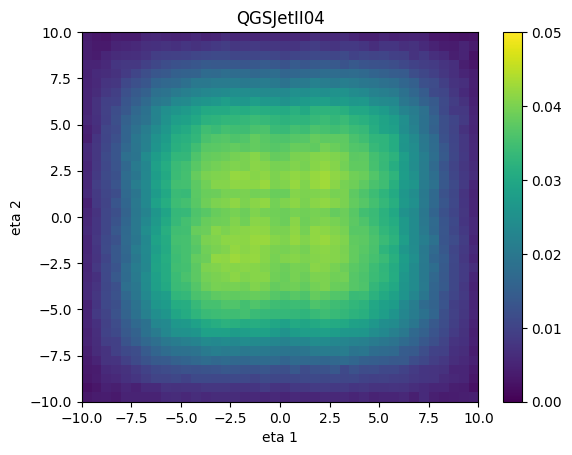

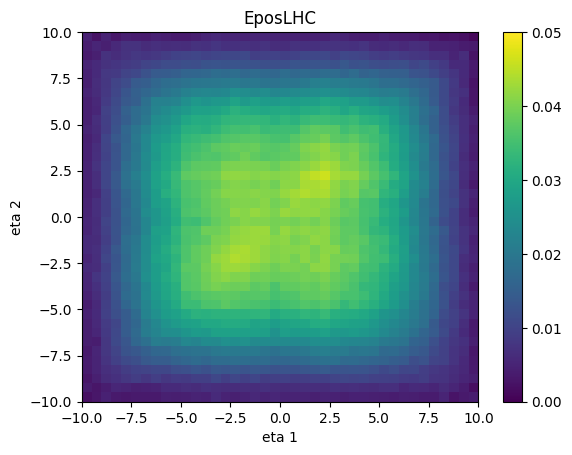

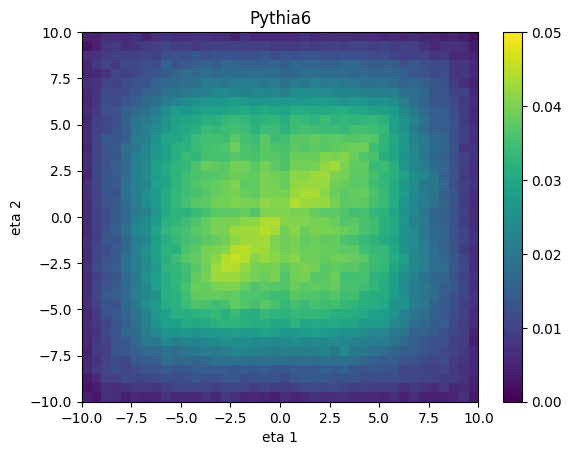

In [3]:
for Model, h in histograms.items():
    plt.figure()
    h2 = h[bh.loc(-10):bh.loc(10):bh.rebin(5), bh.loc(-10):bh.loc(10):bh.rebin(5)]
    h3 = h2[:, sum]
    nxy = h2.values() / nevent
    nx = ny = h3.values() / nevent
    corr = nxy / np.outer(nx, ny) ** 0.5
    print(Model.__name__, np.mean(corr))
    plt.pcolormesh(*h2.axes.edges.T, np.ma.masked_invalid(corr).T)
    plt.xlabel("eta 1")
    plt.ylabel("eta 2")
    plt.colorbar()
    plt.clim(0, 0.05)
    plt.title(Model.__name__)